In [1]:
import numpy as np
from math import log
import operator

<h1> 1. Computing Entrorpy and Informaiton Gain </h1>

In [2]:
# 1. Creating a Toy Dataset for Development

# bottom-up 방식으로 toy dataset 생성
def create_a_dataset():
  D = [[1, 1, 'yes'],
       [1, 1, 'yes'],
       [1, 0, 'no'],
       [0, 1, 'no'],
       [0, 1, 'no']]
  input_feature_names = ['no surfacing', 'flippers']

  return D, input_feature_names

In [3]:
# 2. 엔트로피 계산

# 1) 엔트로피 계산
def calcShannonEnt(dataset):
  N = len(dataset)
  label_counts = {}

  for feature_vect in dataset:
    cur_label = feature_vect[-1]

    if cur_label not in label_counts.keys():
      label_counts[cur_label] = 0
    label_counts[cur_label] += 1

  entropy = 0.0
  for key in label_counts:
    prob = float(label_counts[key])/N
    entropy -= prob * log(prob, 2)

  return entropy

# 2) 엔트로피 정확히 계산 되는지 테스트
my_data, my_feature_names = create_a_dataset()

calcShannonEnt(my_data)

# 3) 데이터셋 변경 후 정확히 계산 되는지 테스트
my_data[0][-1] = 'maybe'
calcShannonEnt(my_data)

1.3709505944546687

<h1> 2. Splitting a node </h1>

In [4]:
# 1. information gain 기준으로 가장 좋은 split 찾는 함수 구현

def chooseBestFeatureToSplit(dataset):
  n_features = len(dataset[0]) - 1
  baseEntropy = calcShannonEnt(dataset) #H(Y)

  bestInfoGain = 0.0
  bsetFeature = -1

  # 하나씩 대조하면서 best feature 찾아 split한다
  for i in range(n_features):
    # 1) 한 col 찾아서 unique 찾음
    feature_list = [observation[i] for observation in dataset]
    unique_vals = set(feature_list)

    # 2) split했을때 그때 엔트로피 계산 : H(Y|X)
    condEntropy = 0.0
    for value in unique_vals:
      subset = split(dataset, i, value)
      # subset 추정
      prob = len(subset) / float(len(dataset))
      condEntropy += prob * calcShannonEnt(subset)
    infoGain = baseEntropy - condEntropy

    # 3) best면 업데이트
    if infoGain > bestInfoGain:
      bestInfoGain = infoGain
      bestFeature = i

  return bestFeature

In [5]:
# 2. 이때 값이 value인 애들만 모아 subset 구성해주는 split()함수 필요

def split(dataset, axis, value):
  res = []
  for feature_vect in dataset:
    if feature_vect[axis] == value:
      # 모델 자르기
      reduced_feature_vect = feature_vect[:axis]
      reduced_feature_vect.extend(feature_vect[axis+1:])
      res.append(reduced_feature_vect)
  return res

In [6]:
# 3. 토이 데이터셋으로 테스트

# 1) split()함수 테스트
my_data, my_classes = create_a_dataset()
print('Test#1: ', split(my_data, 0, 1))
print('Test#2: ', split(my_data, 0, 0))

# 2) chooseBestFeatureToSplit()함수 테스트
chooseBestFeatureToSplit(my_data)

Test#1:  [[1, 'yes'], [1, 'yes'], [0, 'no']]
Test#2:  [[1, 'no'], [1, 'no']]


0

<h1> 3. Recursion 통해 묶으며 학습하기 </h1>

In [7]:
# 1. train_DT 함수 작성

def train_DT(dataset, feature_names):
  # 변수
  class_vals = [instance[-1] for instance in dataset]

  # 끝까지 가면 멈춤
  if class_vals.count(class_vals[0]) == len(class_vals):
    return class_vals[0]

  # 길이 1이어도 멈춤
  if len(dataset[0]) == 1:
    return majority_count(class_vals)

  # split하기위한 best 모양을 찾음
  bestFeature = chooseBestFeatureToSplit(dataset)
  bestFeatureName = feature_names[bestFeature]

  # 그래서 나온 결과 트리
  tree = {bestFeatureName:{}}

  # 이미 사용된 모양은 고려하지 않게 삭제함
  del(feature_names[bestFeature])

  # split 만듦
  feature_vals = [instance[bestFeature] for instance in dataset]
  unique_vals = set(feature_vals)
  for value in unique_vals:
    subset_feature_names = feature_names[:]
    # 각 split에 대해 recursive하 DT 키우기
    tree[bestFeatureName][value] = train_DT(split(dataset, bestFeature, value), subset_feature_names)

  return tree


In [8]:
# 2. majority_count함수 작성

def majority_count(classes):
  class_count = {}
  for vote in classes:
    if vote not in class_count.keys():
      class_count[vote] = 0
    class_count[vote] += 1
  sorted_calss_count = sorted(class_count.items(), key=operator.itemgetter(1), reverse=True)
  return sorted_calss_count[0][0]

In [9]:
# 3. Test

my_data, my_classes = create_a_dataset()
my_tree = train_DT(my_data, my_classes)
print(my_tree)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


# 4. 만든 Decision Tree로부터 예측 수행

In [23]:
# 1. classify_DT함수 작성

def classify_DT(inputTree, feature_names, X_ts):
  # Tree traversal according to the query answering 
  firstStr = list(inputTree)[0] 
  secondDict = inputTree[firstStr] 
  featIndex = feature_names.index(firstStr)
  for key in secondDict.keys():
    if X_ts[featIndex] == key:
    # if the next node is an internal node: keep traversing (recursion) 
      if type(secondDict[key]).__name__=='dict': 
        classLabel = classify_DT(secondDict[key], feature_names, X_ts) 
      # if the next node is a leaf (decision) node: stop and make a prediction 
      else: 
        classLabel = secondDict[key] 
  return classLabel

In [24]:
# 2. classify_DT함수 테스트

X, y = create_a_dataset()
classify_DT(my_tree, y, [1,0])

'no'

<h1> 5. lenses 데이터셋 실습 </h1>

In [25]:
# 1. mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
# 2. lenses.txt 데이터 불러오기
file = open('drive/MyDrive/lenses.txt')
lenses = [inst.strip().split('\t') for inst in file.readlines()]

lensesLables = ['age', 'prescript', 'astigmatic', 'tearRate']

lensesTree = train_DT(lenses, lensesLables)

print(lensesTree)
#createPlot(lensesTree)

{'tearRate': {'normal': {'astigmatic': {'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses', 'young': 'hard', 'presbyopic': 'no lenses'}}, 'myope': 'hard'}}, 'no': {'age': {'pre': 'soft', 'young': 'soft', 'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}}}}}}, 'reduced': 'no lenses'}}


<h1> 6. Visualize </h1>

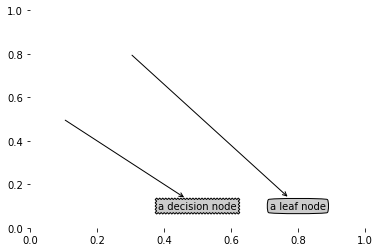

In [29]:
# 1. 추상화, matplot 이용하여 간단한 화살표와 노드 나타내기

import matplotlib.pyplot as plt 
# shape palette 
decisionNode = dict (boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict (arrowstyle="<-") 

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
  createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction', xytext=centerPt, textcoords='axes fraction', va="center", ha="center", bbox=nodeType, arrowprops=arrow_args) 
  
def createPlot(): 
  fig = plt.figure(1, facecolor='white')
  fig.clf() 
  createPlot.ax1 = plt.subplot(111, frameon=False)
  plotNode('a decision node', (0.5, 0.1), (0.1, 0.5), decisionNode) 
  plotNode('a leaf node', (0.8, 0.1), (0.3, 0.8), leafNode) 
  plt.show() 

createPlot()

In [30]:
# 2. tree를 받고 속성을 파악하기 위해 구현하는 utility 함수

def getNumLeafs(myTree): 
  numLeafs = 0 
  firstStr = list(myTree)[0] 
  secondDict = myTree[firstStr] 
  for key in secondDict.keys(): 
    if type(secondDict[key]).__name__== 'dict':
      numLeafs += getNumLeafs(secondDict[key]) 
    else: numLeafs +=1
  return numLeafs 
    
def getTreeDepth(myTree): 
  maxDepth = 0 
  firstStr = list(myTree)[0] 
  secondDict = myTree[firstStr] 
  for key in secondDict.keys(): 
    if type(secondDict [key]).__name__=='dict': 
      thisDepth = 1 + getTreeDepth(secondDict[key]) 
    else: thisDepth = 1 
    if thisDepth > maxDepth:
      maxDepth = thisDepth
  return maxDepth

In [31]:
# 3. Create a demo tree 

def retrieveTree(i): 
  listOfTrees =[{'no surfacing': {0: 'no',
                           1: {'flippers': {0: 'no', 1: 'yes'}}}},
                 {'no surfacing': {0: 'no',
                           1: {'flippers': {0: {'head': {0: 'no',
                                                         1: 'yes'}},
                                                 1: 'no'}}}}
                ]
  return listOfTrees[i]
 
 
demoTree = retrieveTree(1)
print(demoTree) 
print('getNumLealfs(demoTree)=', getNumLeafs(demoTree)) 
print('getTreeDepth(demoTree)=', getTreeDepth(demoTree)) 

demoTree = retrieveTree(0) 
print(demoTree) 
print('getNumLeafs(demoTree)=', getNumLeafs(demoTree)) 
print('getTreeDepth(demoTree)=', getTreeDepth(demoTree))

{'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
getNumLealfs(demoTree)= 4
getTreeDepth(demoTree)= 3
{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
getNumLeafs(demoTree)= 3
getTreeDepth(demoTree)= 2


In [32]:
# 4. Recursive하게 구조 따라가면서 트리의 형태 visualize

def plotTree(myTree, parentPt, nodeTxt): 
  numLeafs = getNumLeafs(myTree) 
  getTreeDepth(myTree) 
  firstStr = list(myTree)[0] 
  cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff) 
  plotMidText(cntrPt, parentPt, nodeTxt)

  plotNode(firstStr, cntrPt, parentPt, decisionNode) 
  
  secondDict = myTree[firstStr] 
  plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD 
  
  for key in secondDict.keys(): 
    if type(secondDict[key]).__name__=='dict':
      plotTree(secondDict[key],cntrPt,str(key)) 
    else: 
      plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW 
      plotNode(secondDict[key],(plotTree.xOff, plotTree.yOff), cntrPt, leafNode) 
      plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key)) 
  plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD 
  

def plotMidText(cntrPt, parentPt, txtString): 
  xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0] 
  yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1] 
  createPlot.ax1.text(xMid, yMid, txtString)

In [33]:
# 5. tree 그리는 함수

def createPlot(inTree): 
  fig = plt.figure(1, facecolor='white') 
  fig.clf() 
  axprops = dict(xticks=[], yticks=[]) 
  createPlot.ax1 = plt.subplot(111, frameon=False, **axprops) 
  plotTree. totalW = float(getNumLeafs(inTree)) 
  plotTree. totalD = float(getTreeDepth(inTree)) 
  plotTree.xOff = -0.5/plotTree.totalW 
  
  plotTree.yOff = 1.0 
  plotTree(inTree, (0.5,1.0), '') 
  plt.show()

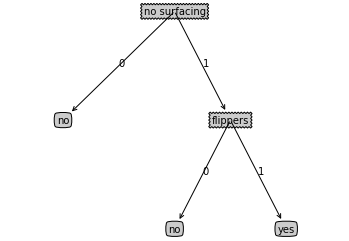

In [34]:
# 6. 전체 테스트

demoTree = retrieveTree(0)
createPlot(demoTree)

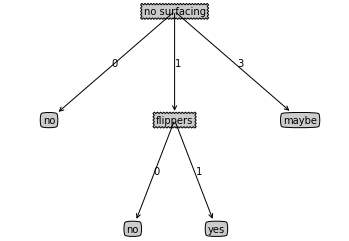

In [35]:
# 7. 학습된 트리 출력

demoTree['no surfacing'][3] = 'maybe'
demoTree
createPlot(demoTree)

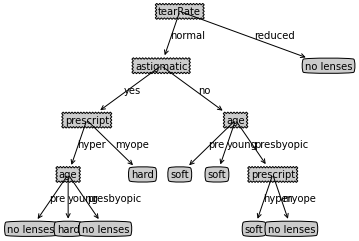

In [37]:
# 8. 데이터로부터 읽어온 트리 출력

file = open('drive/MyDrive/lenses.txt')
lenses = [inst.strip().split('\n') for inst in file.readlines()]

lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lensesType = train_DT(lenses, lensesLabels)
createPlot(lensesTree)